In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd ..

/home/suetin/Projects/VSCode/TennisApp/MainApp/TennisApp


In [3]:
# read the picle file
with open('data/temporary/ball_detections.pkl', 'rb') as f:  # /home/suetin/Projects/VSCode/TennisApp/MainApp/TennisApp/data/temporary/ball_detections.pkl
    ball_positions = pickle.load(f)

In [5]:
ball_positions[:3]

[(None, None), (902, 624), (None, None)]

In [6]:
# convert the list into pandas.DataFrame
df_ball_positions = pd.DataFrame(np.array(ball_positions), columns=['x', 'y'], dtype=float)
# interpolate the missing values
print(df_ball_positions.isna().sum())
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()
print(df_ball_positions.isna().sum())

# # Convert pandas.DataFrame to original format. Back up
# ball_positions = df_ball_positions.astype(int).tolist()  # .to_numpy()
# ball_positions

x    149
y    149
dtype: int64
x    0
y    0
dtype: int64


In [7]:
# MA 
df_ball_positions['y_ma'] = df_ball_positions['y'].rolling(window=5, min_periods=1, center=False).mean()
df_ball_positions['x_ma'] = df_ball_positions['x'].rolling(window=5, min_periods=1, center=False).mean()
df_ball_positions.sample(5)

,x,y,y_ma,x_ma
211,1188.000000,229.500000,252.473913,1193.391304
157,1006.714286,456.857143,421.009524,979.819048
180,1285.000000,737.000000,726.166667,1263.533333
35,911.000000,320.000000,324.800000,906.200000
109,679.200000,395.200000,427.240000,674.640000


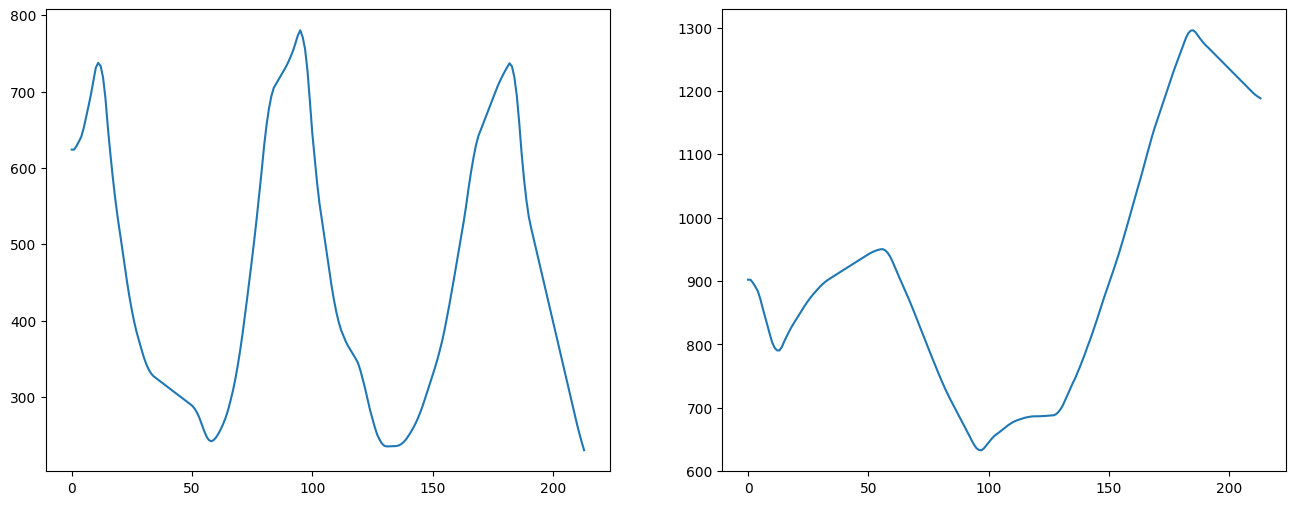

In [8]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(df_ball_positions['y_ma'])
plt.subplot(1, 2, 2)
plt.plot(df_ball_positions['x_ma'])

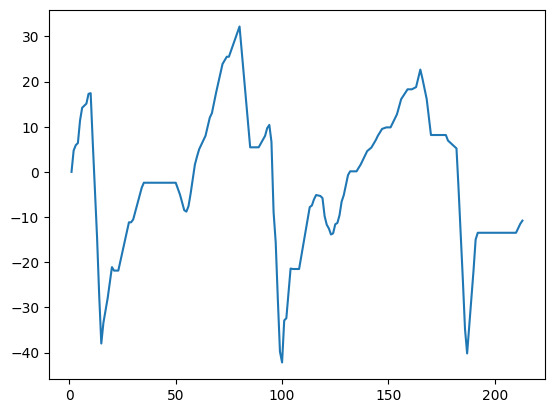

In [9]:
df_ball_positions['delta_y'] = df_ball_positions['y_ma'].diff()

plt.plot(df_ball_positions['delta_y'])

In [10]:
df_ball_positions['ball_hit'] = 0


minimum_change_frames_for_hit = 25

for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1


frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()
df_ball_positions[df_ball_positions['ball_hit']==1]

,x,y,y_ma,x_ma,delta_y,ball_hit
11,787.0,727.0,737.500000,794.800000,6.400000,1
58,931.0,247.0,242.000000,944.600000,-1.600000,1
95,629.0,786.0,780.266667,635.866667,6.666667,1
131,722.0,235.5,235.250000,705.000000,-0.700000,1
182,1304.0,749.0,737.000000,1283.500000,5.200000,1


In [11]:
from src.scripts import BounceDetector

/home/suetin/Projects/VSCode/TennisApp/MainApp/TennisApp


In [12]:
bounce_detector = BounceDetector('./models/ctb_regr_bounce.cbm')  # 
bounce_detector.model

In [13]:
type(ball_positions)

list

In [14]:
ball_positions = np.array(ball_positions)
ball_positions.shape

(214, 2)

In [15]:
x, y = bounce_detector.smooth_predictions(ball_positions[:, 0], ball_positions[:, 1])
x, y

(array([None, 902, None, None, None, None, 829, None, 805, 787, 778, 787, None, 804, None, 822, 827, None, None, None, None, None, None, 870, None, None, None, None, None, 896, 899, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 947, None, 949, None,
        951, 952, 949, None, None, None, None, 904, None, None, 879, None, None, 852, None, 831, None, None, None, None, None, 774, None, None, None, None, 728, None, None, None, None, None, None, None, None, 663, None, None, 641, 632, 629, 629, 635, 639, 643.0, 653, 654, 655.0, 656.0, 657.0, None, None, None, None,
        678, None, None, None, None, 684, 686, 686, 686, None, None, 687, 686, None, 687, 688, 688, None, 688, 688, None, None, None, None, None, None, None, 756, 761, 775, None, None, 806, None, 825, None, 852, None, None, None, None, None, None, 929, None, None, 966, None, None, None, None, None, None, 1061, None,
        1085, None, 1119, None, None, None, No

In [16]:
df, feats = bounce_detector.prepare_features(x, y)
df

,x_diff_1,x_diff_2,x_diff_inv_1,x_diff_inv_2,x_div_1,x_div_2,y_diff_1,y_diff_2,y_diff_inv_1,y_diff_inv_2,y_div_1,y_div_2
94,3,12,0,6,3000000000000000.0,2.0,-9,-23,-9,-77,1.0,0.298701
95,0,3,6,10,0.0,0.3,9,0,-68,-92,-0.132353,-0.0
96,6,6,4,8.0,1.5,0.75,68,77,-24,-48.0,-2.833333,-1.604167
97,4,10,4.0,14,1.0,0.714286,24,92,-24.0,-98,-1.0,-0.938776
98,4.0,8.0,10.0,11.0,0.4,0.727273,24.0,48.0,-74.0,-95.0,-0.324324,-0.505263
99,10.0,14,1,2.0,10.0,7.0,74.0,98,-21,-42.0,-3.52381,-2.333333
100,1,11.0,1.0,2.0,1.0,5.5,21,95.0,-21.0,-42.0,-1.0,-2.261905
101,1.0,2.0,1.0,2.0,1.0,1.0,21.0,42.0,-21.0,-42.0,-1.0,-1.0


In [19]:
bounce_detector.model.predict(df)

array([    0.11482,    0.050047,  -0.0022246,  -0.0030539,   -0.033373,  0.00097427,   -0.027071,   0.0095683])

In [20]:
ball_bounced = bounce_detector.predict(ball_positions[:, 0], ball_positions[:, 1], smooth=False)
ball_bounced

[]